In [1]:
import sys
sys.path.insert(1, '../src')
from util import reset_keras
from util import build_nn
from util import disp_confusion_matrix
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.utils import class_weight
from collections import defaultdict

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", None)
pd.set_option("precision", 3)
sns.set_context("talk") # talk context is good for RISE presentations
# matplotlib.style.use('default')
%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


# **1. Read the preprocessed data**

In [3]:
fn = '../data/clean_data/us_accidents_preprocessed.csv'
df = pd.read_csv(fn)
df.head()

,start_lat,start_lng,temperature(f),humidity(%),pressure(in)_bc,visibility(mi)_bc,wind_speed(mph)_bc,precipitation(in)_bc,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,side_L,side_R,wind_direction_calm,wind_direction_e,wind_direction_n,wind_direction_na,wind_direction_ne,wind_direction_nw,wind_direction_s,wind_direction_se,wind_direction_sw,wind_direction_var,wind_direction_w,start_time_dayname_friday,start_time_dayname_monday,start_time_dayname_saturday,start_time_dayname_sunday,start_time_dayname_thursday,start_time_dayname_tuesday,start_time_dayname_wednesday,start_time_daypart_afternoon,start_time_daypart_early_morning,start_time_daypart_evening,start_time_daypart_late_night,start_time_daypart_morning,start_time_daypart_night,season_fall,season_spring,season_summer,season_winter,crossing,junction,traffic_signal,weather_clear,weather_fair,weather_cloudy,weather_windy,weather_rain,weather_snow,weather_obscuration,weather_sand,severity
0,39.88,-84.06,36.90,91.00,"221,782.40",2.40,2.49,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,3
1,39.94,-82.80,37.90,100.00,"220,916.48",2.40,2.49,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2
2,39.06,-84.06,36.00,100.00,"221,204.84",2.40,1.53,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,2
3,39.75,-84.20,35.10,96.00,"220,340.62",2.30,1.75,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,3
4,39.62,-84.20,36.00,89.00,"220,916.48",1.95,1.53,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,2


# **2. Split the entire dataset into training, validation and testing datasets**
The entire dataset was split into 80% training and 20% testing datasets. The training dataset was further split into 80% training and 20% validation datasets.

In [4]:
# train, test split
seed = 15
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:,-1], test_size=0.2, random_state=seed, stratify=df.iloc[:,-1])
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)
%reset_selective -f df

# **3. Convert labels of training, validation, and testing datasets to binary values to represent each category**

In [6]:
from tensorflow.keras.utils import to_categorical
num_classes = len(y_train.unique())

# set class values as zero indexed
y_train2 = y_train - y_train.unique().min()
y_val2 = y_val - y_train.unique().min()
y_test2 = y_test - y_train.unique().min()

y_train_cat = to_categorical(y_train2, num_classes=num_classes)
y_val_cat = to_categorical(y_val2, num_classes=num_classes)
y_test_cat = to_categorical(y_test2, num_classes=num_classes)

np.sum(y_train_cat, axis=0)

array([  18603., 1890705.,  675735.,   77479.], dtype=float32)

# **4.  Standardize continuous variables**

In [7]:
# standardize
feat_name_cont = ['start_lat', 'start_lng',
                  'temperature(f)', 'humidity(%)','pressure(in)_bc',
                  'visibility(mi)_bc', 'wind_speed(mph)_bc', 'precipitation(in)_bc'
                  ]

ss = StandardScaler()
x_train_scaled = x_train.copy()
x_train_scaled[feat_name_cont] = ss.fit_transform(x_train[feat_name_cont])

x_val_scaled = x_val.copy()
x_val_scaled[feat_name_cont] = ss.transform(x_val[feat_name_cont])

x_test_scaled = x_test.copy()
x_test_scaled[feat_name_cont] = ss.transform(x_test[feat_name_cont])

# **5. Calculate the weight for each class using sklearn to address class imbalance problem**

In [8]:
w = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
my_class_weight = dict(enumerate(w))
my_class_weight

{0: 35.78081492232435,
 1: 0.3520541279575608,
 2: 0.985046652903875,
 3: 8.591108558448095}

# **6. Build a fully connected neural network for classification**

In [9]:
n_layers = 3 
n_units = [1800, 900, 450]

n_classes = len(y_train.unique())
dropout_rate = None

activation = 'relu'
initializer = 'he_uniform'
optimizer = keras.optimizers.Nadam(learning_rate=1e-5,
                                   epsilon=1e-10)
metrics = ['AUC', 'accuracy', 'Precision', 'Recall']

mdl = build_nn(n_layers = n_layers, n_units=n_units, n_classes=n_classes,
               input_shape=x_train_scaled.shape[1], activation=activation,
               initializer=initializer, optimizer=optimizer,
               metrics=metrics, dropout_rate=dropout_rate);
mdl.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h1 (Dense)                   (None, 1800)              178200    
_________________________________________________________________
batch_normalization (BatchNo (None, 1800)              7200      
_________________________________________________________________
h2 (Dense)                   (None, 900)               1620900   
_________________________________________________________________
batch_normalization_1 (Batch (None, 900)               3600      
_________________________________________________________________
h3 (Dense)                   (None, 450)               405450    
_________________________________________________________________
batch_normalization_2 (Batch (None, 450)               1800      
_________________________________________________________________
output (Dense)               (None, 4)                 1

## **6.1 Define an early stopping to prevent overfitting and callback to save the best performing model**

In [10]:
# define early stopping and callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               verbose=1,
                               patience=10,
                               mode='auto',
                               restore_best_weights=True)
mdl_chk_points =  keras.callbacks.ModelCheckpoint('../models/best_model_3_layers.hdf5',
                                                  save_best_only=True)
csv_logger = keras.callbacks.CSVLogger('../models/hist_3_layers.csv', separator=",", append=False)

## **6.2 Train the neural network**

In [69]:
batch_size = 2**10
n_epochs = 50

history = mdl.fit(x_train_scaled, y_train_cat,
                  epochs=n_epochs,                               
                  verbose=1,
                  batch_size=batch_size,
                  class_weight = my_class_weight, 
                  validation_data = (x_val_scaled, y_val_cat),
                  validation_batch_size=batch_size,
                  callbacks=[early_stopping, mdl_chk_points, csv_logger],
                 )
    

Epoch 1/50
2601/2601 [==============================] - 51s 19ms/step - loss: 1.2153 - auc: 0.6174 - accuracy: 0.3528 - precision: 0.3769 - recall: 0.2258 - val_loss: 1.2438 - val_auc: 0.7269 - val_accuracy: 0.4546 - val_precision: 0.4998 - val_recall: 0.3002
Epoch 2/50
2601/2601 [==============================] - 48s 18ms/step - loss: 0.9507 - auc: 0.7457 - accuracy: 0.4722 - precision: 0.5236 - recall: 0.3193 - val_loss: 1.1193 - val_auc: 0.7762 - val_accuracy: 0.5005 - val_precision: 0.5537 - val_recall: 0.3532
Epoch 3/50
2601/2601 [==============================] - 48s 18ms/step - loss: 0.8906 - auc: 0.7870 - accuracy: 0.5115 - precision: 0.5683 - recall: 0.3648 - val_loss: 1.0617 - val_auc: 0.7970 - val_accuracy: 0.5196 - val_precision: 0.5747 - val_recall: 0.3765
Epoch 4/50
2601/2601 [==============================] - 46s 18ms/step - loss: 0.8615 - auc: 0.8035 - accuracy: 0.5280 - precision: 0.5857 - recall: 0.3879 - val_loss: 1.0284 - val_auc: 0.8087 - val_accuracy: 0.5329 - val

In [11]:
# mdl = tf.keras.models.load_model('../models/best_model_3_layers.hdf5')
# history=pd.read_csv('../models/hist_3_layers.csv')

## **6.3 Plot the neural network**

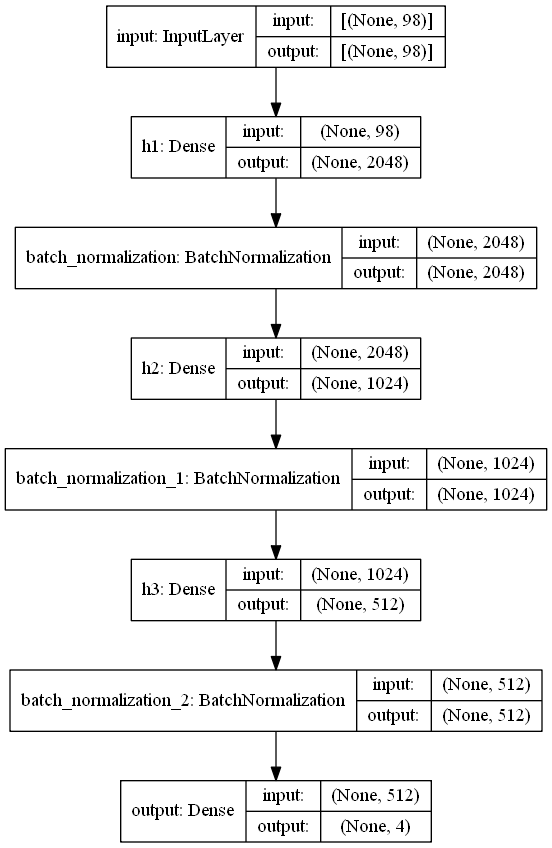

In [15]:
tf.keras.utils.plot_model(mdl, show_shapes=True, expand_nested=True)

# **7. Generate performance curves**

In [12]:
y_pred = mdl.predict(x=x_test_scaled, workers=14, use_multiprocessing=True)
y_pred[:10, :].round(2)

array([[0.  , 0.68, 0.32, 0.  ],
       [0.  , 0.74, 0.21, 0.05],
       [0.  , 0.36, 0.47, 0.16],
       [0.1 , 0.84, 0.03, 0.03],
       [0.  , 0.22, 0.08, 0.71],
       [0.  , 0.53, 0.44, 0.03],
       [0.  , 0.84, 0.12, 0.05],
       [0.02, 0.1 , 0.48, 0.4 ],
       [0.  , 0.29, 0.71, 0.  ],
       [0.  , 0.72, 0.27, 0.02]], dtype=float32)

# **8. Generate loss curves**

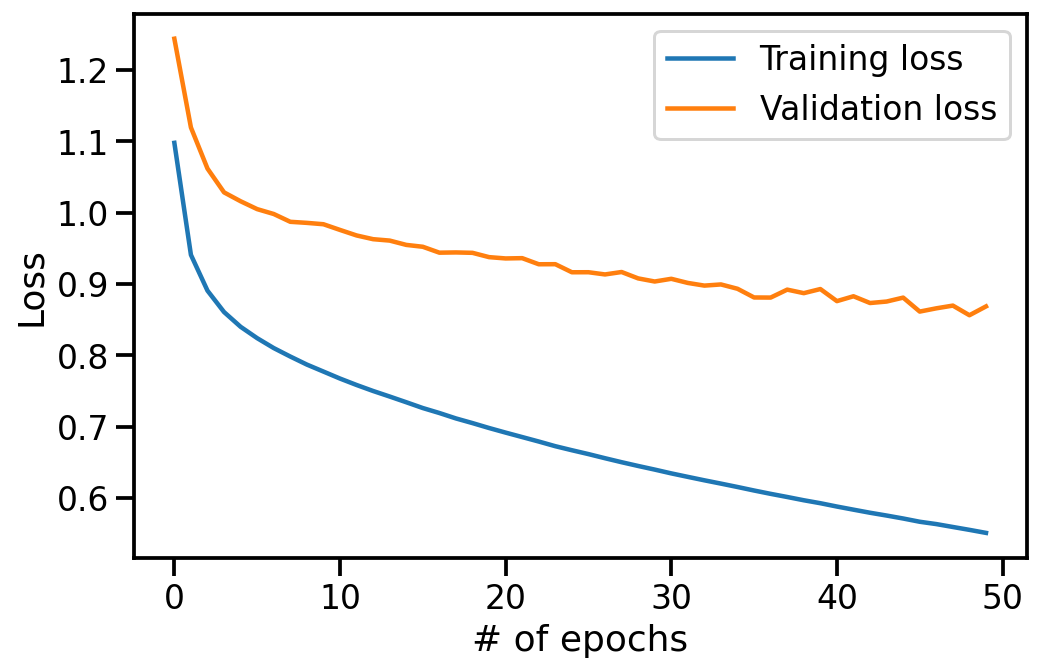

In [13]:
plt.subplots(figsize=(8, 5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss']);
# plt.savefig("../figures/loss.svg",
#             dpi=300, bbox_inches='tight', facecolor="white")

# **9. Generate performance curves**

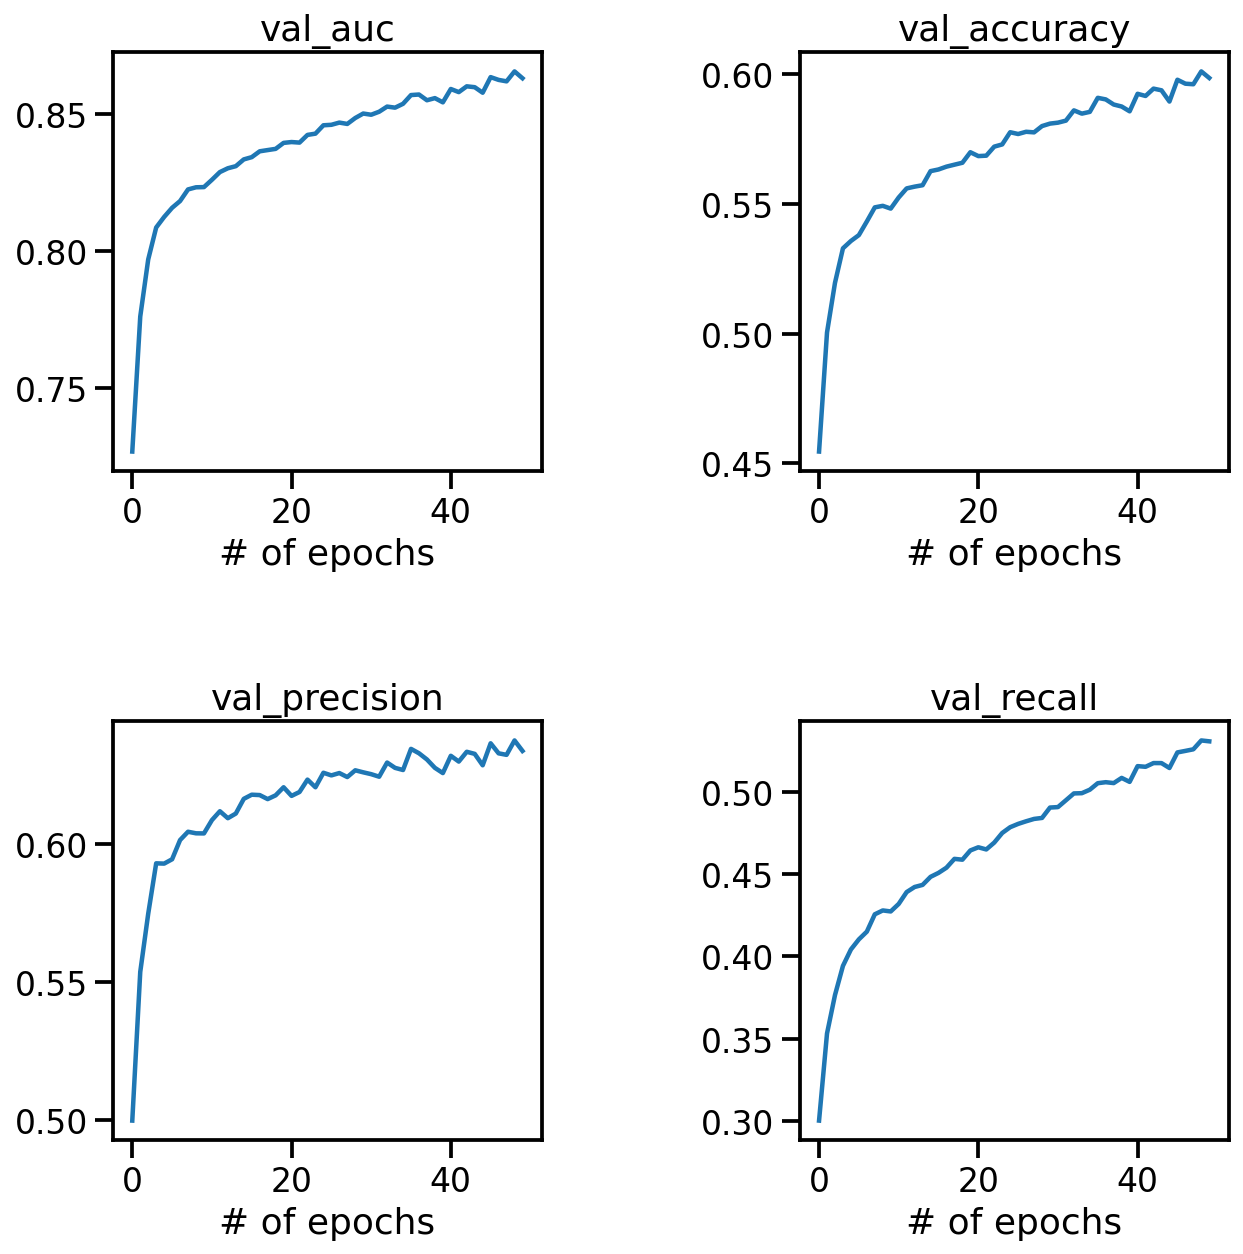

In [14]:
# history = pd.DataFrame(history.history)
metric_name = ['val_auc', 'val_accuracy', 'val_precision', 'val_recall']
plt.subplots(figsize = (10, 10))
plt.subplots_adjust(wspace = 0.6)
plt.subplots_adjust(hspace = 0.6)

c = 1
for mn in metric_name:
    plt.subplot(2, 2, c)  
    plt.plot(history[mn])
    plt.title(mn)
    plt.xlabel('# of epochs')
    c += 1
plt.show()

# **10. Generate predicted labels**
The predicted labels are probabilities. Therefore, varying threshold of probability will change the results of confusion matrix.

In [15]:
cf_mat = confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1))
cf_mat_norm = cf_mat /(np.sum(cf_mat, axis=1)[:, None])
cf_mat_norm.round(2)

array([[0.75, 0.1 , 0.08, 0.07],
       [0.03, 0.59, 0.28, 0.11],
       [0.02, 0.19, 0.65, 0.14],
       [0.02, 0.17, 0.27, 0.53]])

# **11. Generate a performance report using imbalanced learn**

In [16]:
print(classification_report_imbalanced(y_test_cat.argmax(axis=1)+1, y_pred.argmax(axis=1)+1))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.17      0.75      0.97      0.27      0.86      0.72      5814
          2       0.88      0.59      0.81      0.70      0.69      0.47    590846
          3       0.45      0.65      0.73      0.53      0.69      0.47    211167
          4       0.12      0.53      0.88      0.20      0.69      0.45     24212

avg / total       0.75      0.60      0.79      0.64      0.69      0.47    832039



#### close the current keras session

In [17]:
from tensorflow.keras import backend as K
K.clear_session()

# **12. Generate a confusion matrix**

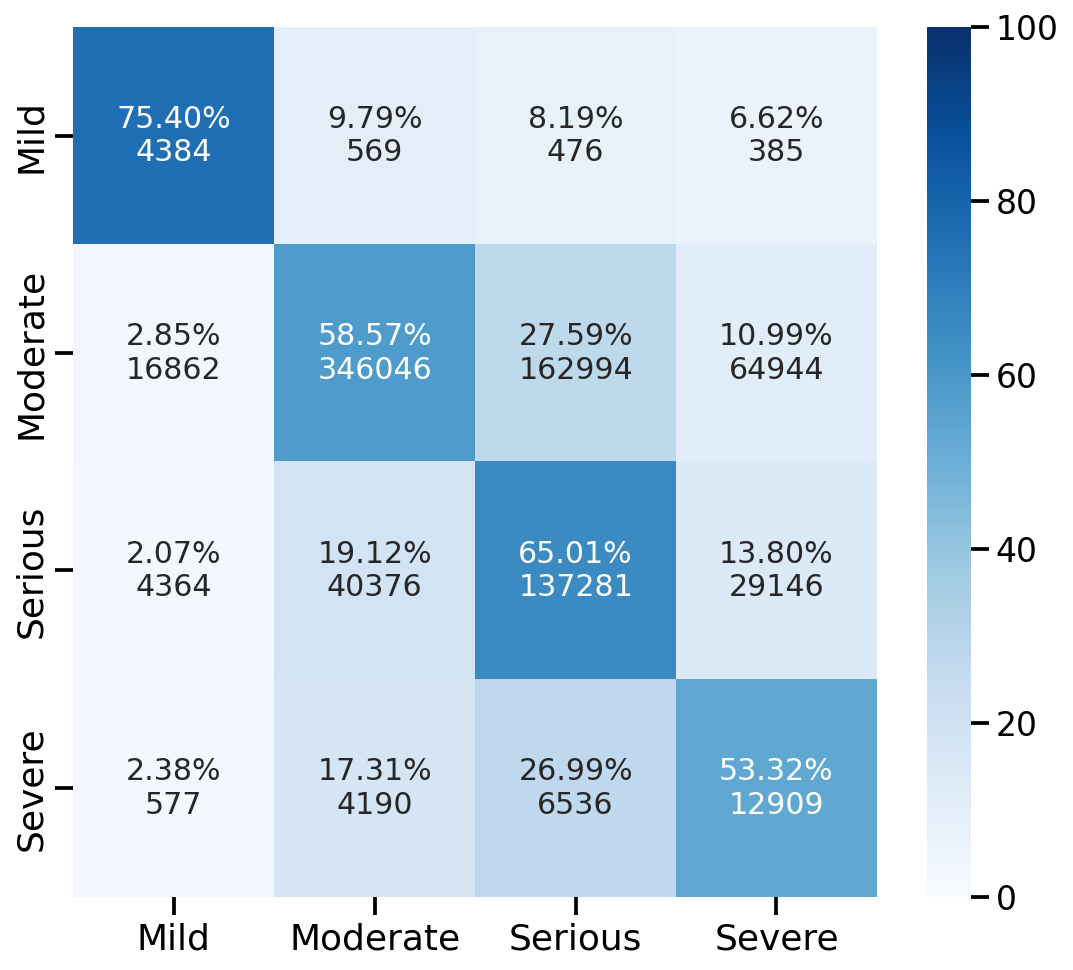

In [18]:
plt.subplots(figsize=(9, 8))
ax = disp_confusion_matrix(cf_mat,
                          0, 100,
                          cmap='Blues',
                          annot_kws={"size": 15}
                          )
fontsize = 18
ax.set_yticklabels(['Mild', 'Moderate', 'Serious', 'Severe'],
                   fontdict={"size": fontsize}, va='center')
ax.set_xticklabels(['Mild', 'Moderate', 'Serious', 'Severe'],
                   fontdict={"size": fontsize}, ha='center');

# plt.savefig("../figures/confusion_mat.svg",
#             dpi=300, bbox_inches='tight', facecolor="white")